# Hinged cylindrical isotropic roof

In [1]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from dolfinx import plot, default_scalar_type

from tqdm import tqdm
import pyvista

# Simulation setup

In [2]:
pyvista.start_xvfb()

In [2]:
nex = int(16)
ney = int(16)

PSRI_control = True

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2",
            5 : "qua_S2",}

ele_index = 4
ele_type = ele_dict[ele_index]


if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

elif ele_type == "qua_S2":
    cell_type = CellType.quadrilateral

In [3]:
from pathlib import Path
thickness = 12.7
if PSRI_control:
    results_folder = Path(f"results/nonlinear-naghdi/PSRI/hinged-roof/thickness-{thickness}/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear-naghdi/FI/hinged-roof/thickness-{thickness}/{nex}_{ney}_{ele_type}")

results_folder.mkdir(exist_ok=True, parents=True)

# Mesh

In [4]:
r = 2540.0
L = 254.0
rad = 0.1

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [r*rad, L]]), 
                        [nex, ney], cell_type)

tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
if ele_index == 5:
    S2 = element("Serendipity", cell, degree=2)
elif ele_index == 2:
    B3 = element("Bubble", cell, degree=3)

## Plot mesh

In [8]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
plotter.show()
plotter.close()

Widget(value='<iframe src="http://localhost:40409/index.html?ui=P_0x7f49ea473350_0&reconnect=auto" class="pyvi…

# Material

In [5]:
E, nu = 3102.75, 0.3 
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = Constant(mesh, default_scalar_type(thickness))

# Initial Shape

In [6]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0] / r), x[1], r * ufl.cos(x[0] / r)])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(ufl.inner(n, n))

n0_ufl = unit_normal(phi0_ufl)


def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(ufl.inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(ufl.inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## Plot initial shape

In [20]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=20)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show()
plotter.close()

Widget(value='<iframe src="http://localhost:40409/index.html?ui=P_0x7f49d853f110_0&reconnect=auto" class="pyvi…

# Shell element

In [7]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
elif ele_type == "qua_S2":
    naghdi_shell_element = mixed_element(
        [blocked_element(S2, shape=(3,)), blocked_element(S2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = ufl.split(q_func) # current displacement and rotation

# Shell model

In [8]:
# current deformation gradient 
F = ufl.grad(u_func) + ufl.grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = ufl.grad(phi0_ufl).T * ufl.grad(phi0_ufl)
b0_ufl = 0.5*( ufl.grad(phi0_ufl).T * ufl.grad(n0_ufl) + ufl.grad(n0_ufl).T * ufl.grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return 0.5 * (F.T * ufl.grad(d) + ufl.grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*ufl.inner(N, epsilon(F))

psi_b = 0.5*ufl.inner(M, kappa(F, d))

psi_s = 0.5*ufl.inner(T, gamma(F, d))

# Weak form Equation with PSRI

In [9]:
if ele_type == "qua_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
        
elif ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
f = Constant(mesh, default_scalar_type((0.0, 0.0, 0.0, 0.0, 0.0)))
Wext = ufl.inner(f, q_func)*dx_f

Fint = ufl.derivative(Pi_PSRI, q_func, q_test)
Fext = ufl.derivative(Wext, q_func, q_test)

Residual = Fint - Fext
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Boundary conditions

In [10]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

Q0 = naghdi_shell_FS.sub(0)
Q1 = naghdi_shell_FS.sub(1)

u_clamped = Function(u_FS) # default value is 0
theta_clamped = Function(theta_FS) # default value is 0

## Top: Symmetric $u_2 = \theta_1 = 0$

In [11]:
def top_boundary(x):
    return np.isclose(x[1], L)

top_facets = locate_entities_boundary(mesh, fdim, top_boundary)

# u2 = 0 on the top boundary
u_id = int(1)
symm_dofs_u_top = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, top_facets)
bc_u_top = dirichletbc(u_clamped, symm_dofs_u_top, Q0.sub(u_id))

# theta1 = 0 on the top boundary
theta_id = int(0)
symm_dofs_theta_top = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, top_facets)
bc_theta_top = dirichletbc(theta_clamped, symm_dofs_theta_top, Q1.sub(theta_id))

## Left: Symmetric $u_1 = \theta_2 = 0$

In [12]:
def left_boundary(x):
    return np.isclose(x[0], 0.0)

left_facets = locate_entities_boundary(mesh, fdim, left_boundary)

# u1 = 0 on the left boundary
u_id = int(0)
symm_dofs_u_left = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, left_facets)
bc_u_left = dirichletbc(u_clamped, symm_dofs_u_left, Q0.sub(u_id))

# theta2 = 0 on the left boundary
theta_id = int(1)
symm_dofs_theta_left = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, left_facets)
bc_theta_left = dirichletbc(theta_clamped, symm_dofs_theta_left, Q1.sub(theta_id))

## Right: Hinged $u_1 = u_2 = u_3 = 0$

In [13]:
def right_boundary(x):
    return np.isclose(x[0], r*rad)

right_facets = locate_entities_boundary(mesh, fdim, right_boundary)

# u1, u2, u3 = 0 on the clamped boundary
hinged_dofs_u_right = locate_dofs_topological((Q0, u_FS), fdim, right_facets)
bc_u_right = dirichletbc(u_clamped, hinged_dofs_u_right, Q0)

In [14]:
bcs = [bc_u_top, bc_theta_top, bc_u_left, bc_theta_left, bc_u_right]

# Point Source

In [15]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmap
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))
        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [16]:
# Point source
if mesh.comm.rank == 0:
    ps_points = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    ps_points = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cells, basis_values = compute_cell_contributions(naghdi_shell_FS, ps_points)

# Arc length solver

In [17]:
from ArclengthProblem import ArclengthProblem

aproblem = ArclengthProblem(Fint, Fext, q_func, lmbda0= 0.0, bcs=bcs,
                              J=Jacobian, 
                              petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
                              ps_cells=ps_cells, ps_basis_values=basis_values, ps_direction=2)
aproblem.max_it = 20

In [18]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")

## Newton steps with 2nd order predictions

In [ ]:
nstep = 400

Fc_list = np.zeros(nstep)

q_func.x.array[:] = 0.0

bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

aproblem.reset()
if mesh.comm.rank == 0:
    u3_list = np.zeros(nstep)

i = 0
ds_max = 0.0
pbar = tqdm(total=nstep)

while i < nstep:
    if i < 3:
        Pred = False
        Fc = -10 * i
    else:
        Pred = True
        Fc = 0.0
    
    n, converged = aproblem.NewtonStep(Fc, Pred)
        
    if converged:
        q_func.x.scatter_forward()
        Fc = aproblem.lmbda
        Fc_list[i] = Fc
        
        if not Pred:
            ds_max = max(aproblem.ds, ds_max)
        # write output
        if ele_type == "qua_P1" or ele_type == "tri_P1":
            phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
        else:
            phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
            
        if ele_type == "tri_P2B3":
            u_P2B3 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_P2B3)
            theta_sol = q_func.sub(1).collapse()
        elif ele_type == "qua_S2":
            u_S2 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_S2)
            
            theta_S2 = q_func.sub(1).collapse()
            theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
            theta_sol = Function(theta_FS)
            theta_sol.interpolate(theta_S2)
            
        else:
            u_sol = q_func.sub(0).collapse()
            theta_sol = q_func.sub(1).collapse()
        
        phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
        phi_sol = Function(phi_FS)
        phi_sol.interpolate(phi_expr)
        
        file_u.write_function(u_sol, i)
        file_theta.write_function(theta_sol, i)
        file_phi.write_function(phi_sol, i)
        
        # calculate u3 at the point load
        u3_bb = 0.0
        u3_func = q_func.sub(0).sub(2).collapse()
        if len(ps_cells) > 0:
            u3_bb = u3_func.eval(bb_point, ps_cells[0])[0]
        u3_bb = mesh.comm.allreduce(u3_bb, op=MPI.SUM)
        if mesh.comm.rank == 0:
            u3_list[i] = u3_bb
            print(f"Load step {i:d}, Number of iterations: {n:d}, " 
                f"Load: {Fc:.2f}, Disp: {u3_bb:.2f}, "
                f"ds: {aproblem.ds:.2f}, s: {aproblem.s:.2f}", flush=True)
            
        # adaptive step size control
        if n < 4:
            aproblem.ds = min(1.2*aproblem.ds, ds_max)
        if n > 6:
            aproblem.ds *= 0.8
            
        if Fc_list[i] < - 750.0:
            break
        
        i += 1
        pbar.update(1)
    else:
        aproblem.ds *= 0.5

   
file_u.close()
file_theta.close()
file_phi.close()
pbar.close()


## Arc length steps with 2nd order predictions

In [ ]:
nstep = 400

Fc_list = np.zeros(nstep)

q_func.x.array[:] = 0.0

bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

aproblem.reset()
if mesh.comm.rank == 0:
    u3_list = np.zeros(nstep)

i = 0
ds_max = 0.0
pbar = tqdm(total=nstep)
while i < nstep:
    if i < 3:
        Pred = False
        Fc = -10 * i
        n, converged = aproblem.NewtonStep(Fc, Pred)
    else:
        n, converged = aproblem.ArclengthStep()
        
    if converged:
        q_func.x.scatter_forward()
        Fc = aproblem.lmbda
        Fc_list[i] = Fc
        
        if not Pred:
            ds_max = max(aproblem.ds, ds_max)
        # write output
        if ele_type == "qua_P1" or ele_type == "tri_P1":
            phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
        else:
            phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
            
        if ele_type == "tri_P2B3":
            u_P2B3 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_P2B3)
            theta_sol = q_func.sub(1).collapse()
        elif ele_type == "qua_S2":
            u_S2 = q_func.sub(0).collapse()
            u_sol = Function(phi_FS)
            u_sol.interpolate(u_S2)
            
            theta_S2 = q_func.sub(1).collapse()
            theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
            theta_sol = Function(theta_FS)
            theta_sol.interpolate(theta_S2)
            
        else:
            u_sol = q_func.sub(0).collapse()
            theta_sol = q_func.sub(1).collapse()
        
        phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
        phi_sol = Function(phi_FS)
        phi_sol.interpolate(phi_expr)
        
        file_u.write_function(u_sol, i)
        file_theta.write_function(theta_sol, i)
        file_phi.write_function(phi_sol, i)
        
        # calculate u3 at the point load
        u3_bb = 0.0
        u3_func = q_func.sub(0).sub(2).collapse()
        if len(ps_cells) > 0:
            u3_bb = u3_func.eval(bb_point, ps_cells[0])[0]
        u3_bb = mesh.comm.allreduce(u3_bb, op=MPI.SUM)
        if mesh.comm.rank == 0:
            u3_list[i] = u3_bb
            print(f"Load step {i:d}, Number of iterations: {n:d}, " 
                f"Load: {Fc:.2f}, Disp: {u3_bb:.2f}, "
                f"ds: {aproblem.ds:.2f}, s: {aproblem.s:.2f}", flush=True)
            
        # adaptive step size control
        if n < 4:
            aproblem.ds = min(1.2*aproblem.ds, ds_max)
        if n > 6:
            aproblem.ds *= 0.8
        if Fc_list[i] < - 750.0:
            break
        
        i += 1
        pbar.update(1)
    else:
        aproblem.ds *= 0.5

   
file_u.close()
file_theta.close()
file_phi.close()
pbar.close()


# Post-processing

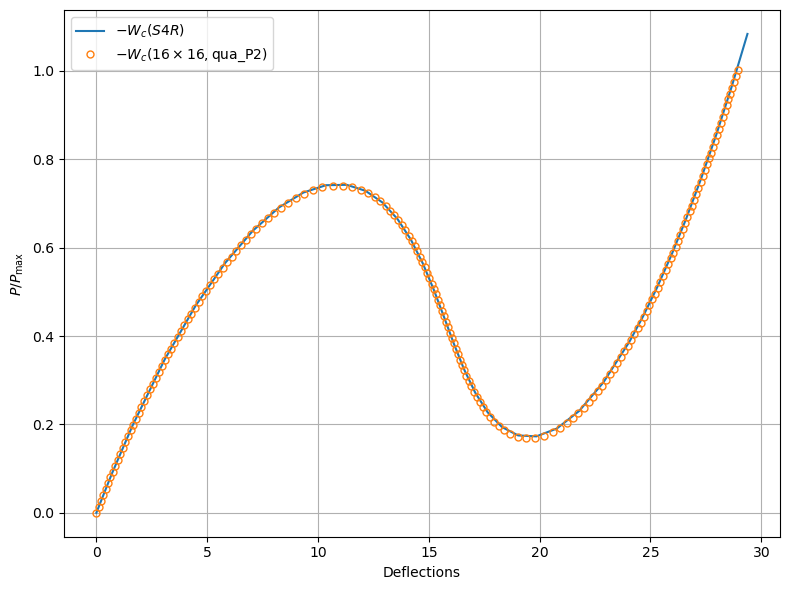

In [20]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    u3_list = u3_list[:i+1]
    Fc_list = Fc_list[:i+1]
    Fc_max = 750.0
    np.savetxt(results_folder/"u3_list.txt", u3_list)
    np.savetxt(results_folder/"Fc_list.txt", Fc_list)
    if thickness == 12.7:
        P_S4R = np.array([0.0000, 0.0877, 0.1980, 0.3473, 0.4686, 0.5647, 0.6381, 0.6908,
                        0.7246, 0.7412, 0.7421, 0.7286, 0.7023, 0.6649, 0.6182,
                        0.5643, 0.5055, 0.4442, 0.3830, 0.3245, 0.2717, 0.2272,
                        0.1940, 0.1750, 0.1729, 0.1905, 0.2303, 0.2950, 0.3871,
                        0.4443, 0.5093, 0.5826, 0.6644, 0.7551, 0.8549, 0.9643, 1.0835])
        
        Wc_S4R = np.array([0.0000, 0.6930, 1.6380, 3.0870, 4.4770, 5.8020, 7.0570, 8.2370, 
                        9.3390, 10.358, 11.293, 12.141, 12.903, 13.583, 14.188,
                        14.728, 15.217, 15.676, 16.125, 16.590, 17.094, 17.657,
                        18.299, 19.028, 19.852, 20.771, 21.780, 22.875, 24.049,
                        24.663, 25.293, 25.940, 26.601, 27.276, 27.964, 28.663, 29.374])
    elif thickness == 6.35:
        P_S4R = np.array([0.0000, 0.0517, 0.1182, 0.1583, 0.1837, 0.1914, 0.1953, 0.1950,
                        0.1901, 0.1806, 0.1671, 0.1323, 0.0923, 0.0504, 0.0083,
                        -0.0312, -0.0622, -0.0739, -0.0861, -0.1001, -0.1142, -0.1247,
                        -0.1288, -0.1271, -0.1196, -0.1055, -0.0825, -0.0484, -0.0006,
                        0.0626, 0.1427, 0.2403, 0.3559, 0.4898, 0.6417, 0.8114, 1.0313])
        
        Wc_S4R = np.array([0.0000, 1.8460, 5.2710, 8.2570, 10.799, 11.904, 12.892, 13.752, 
                        14.472, 15.050, 15.501, 16.145, 16.602, 16.915, 17.008,
                        16.697, 15.780, 15.206, 14.767, 14.520, 14.451, 14.862,
                        15.778, 16.961, 18.320, 19.817, 21.420, 23.100, 24.824,
                        26.565, 28.302, 30.023, 31.720, 33.388, 35.024, 36.626, 38.450])

    plt.figure(figsize=(8.0, 6.0))
    plt.plot(Wc_S4R, P_S4R, "-", label="$-W_c(S4R)$")
    plt.plot(-u3_list, -Fc_list / Fc_max, "o", markersize=5, markerfacecolor='none',
             markevery = 1, label=f"$-W_c({nex}\\times{ney},${ele_type})")
    plt.xlabel("Deflections")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")